## Sentiment analysis of IMDB reviews

In this final exercise, we explore text classification. We use the sample dataset of IMDB reviews. First, we fine-tune the language model, then use it as an encoder for a classification model. In order to get some insight into how the model works, we visualize word embeddings.

In this notebook, you will find sections with `#TO DO` that you need to replace with your code.

In [1]:
# Install requirements
!pip install scipy
!pip install --upgrade fastai

     |████████████████████████████████| 187 kB 24.8 MB/s eta 0:00:01
  Attempting uninstall: fastai
    Found existing installation: fastai 2.5.3
    Uninstalling fastai-2.5.3:
      Successfully uninstalled fastai-2.5.3


In [2]:
from fastai.text.all import *

In [4]:
path = untar_data(URLs.IMDB_SAMPLE)

In [5]:
path.ls()

(#2) [Path('/home/azureuser/.fastai/data/imdb_sample/texts.csv'),Path('/home/azureuser/.fastai/data/imdb_sample/models')]

In [6]:
df = pd.read_csv(path/"texts.csv")
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


### Fine-tuning the language model
Before we train the classification model, we fine-tune a language model in order to capture the the dataset's vocabulary.

#### Define the language model's dataloaders

In [7]:
#TO DO
dls_lm = TextDataLoaders.from_csv(path=path, csv_fname='texts.csv', text_col="text", label_col="label", validation_col="is_valid", is_lm=True)
dls_lm.show_batch(max_n=3)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj pixar has had massive success over the years with the full - length xxup cgi animated movies they have made . "" a xxmaj bug 's xxmaj life "" was the second of a whole bunch of features they have made so far , xxunk by the company 's feature - length debut , the xxunk "" toy xxmaj story "" , which was the first ever feature - length","xxmaj pixar has had massive success over the years with the full - length xxup cgi animated movies they have made . "" a xxmaj bug 's xxmaj life "" was the second of a whole bunch of features they have made so far , xxunk by the company 's feature - length debut , the xxunk "" toy xxmaj story "" , which was the first ever feature - length xxup"
1,"on late - night xxmaj italian xxup tv and recall not being especially xxunk over by it , so that i was genuinely surprised by how much i enjoyed it this time around ( also bearing in mind the xxunk lack of enthusiasm shown towards the film here and elsewhere when it was first announced as an upcoming xxup dvd release from xxmaj criterion ) . \n\n xxmaj incidentally , xxup fanfan","late - night xxmaj italian xxup tv and recall not being especially xxunk over by it , so that i was genuinely surprised by how much i enjoyed it this time around ( also bearing in mind the xxunk lack of enthusiasm shown towards the film here and elsewhere when it was first announced as an upcoming xxup dvd release from xxmaj criterion ) . \n\n xxmaj incidentally , xxup fanfan xxup"
2,"cake at the end -- i hope they gave her an extremely - large xxunk . \n\n ( speaking of which , where in the world are you going to find a fur coat factory , a xxunk with a xxmaj xxunk xxmaj goldberg assembly line , and a xxunk restaurant all located within the same building -- as you do in the climax of this film ? ) xxmaj of course","at the end -- i hope they gave her an extremely - large xxunk . \n\n ( speaking of which , where in the world are you going to find a fur coat factory , a xxunk with a xxmaj xxunk xxmaj goldberg assembly line , and a xxunk restaurant all located within the same building -- as you do in the climax of this film ? ) xxmaj of course ,"


#### Train the language model
Let's fine tune the language model on our dataset.

In [8]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

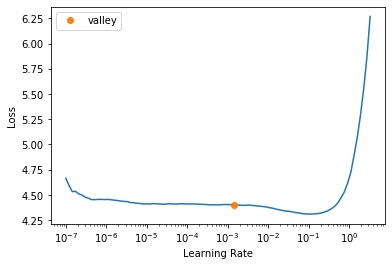

In [9]:
lr = learn.lr_find()

In [10]:
lr = lr.valley

In [11]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.335239,4.186187,0.266958,65.771515,00:39


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.187477,4.102955,0.273972,60.518875,00:49
1,4.112506,4.029679,0.278937,56.242844,00:49
2,4.025763,3.991801,0.281112,54.152317,00:49
3,3.953269,3.974808,0.281453,53.239918,00:49
4,3.911834,3.971949,0.281625,53.087917,00:49


In [12]:
learn.save_encoder('finetuned')

#### Evaluate the language model
Let's try to have a peek at our language model. First, let's try a few examples of predictive text, then let's have a look a word embeddings.

**Predictive text**

In [13]:
TEXT = "I hated this movie because"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [14]:
print("\n".join(preds))

i hated this movie because i was looking for money and had to pay for it . The movie was shot in ' the Gun House ' and this movie was shot at the Naval Academy at West
i hated this movie because it was a movie about " the Western Top " . The plot was so violent and ugly that it turned out to be a bizarre one . Bill Maher was very awful .


**Visualize the word embeddings**
Let's compute the distance between word embeddings in a few examples, then visualize word embeddings in a scatter plot.

In [16]:
from scipy.spatial.distance import cosine as dist
from sklearn.manifold import TSNE

In [17]:
net = learn.model
encoder = net[0]
enc = list(encoder.children())[0]
w = enc.weight

In [18]:
embeddings = {dls_lm.vocab[i]: w[i].cpu().detach().numpy() for i in range(len(w))}

In [19]:
dist(embeddings["movie"], embeddings["show"])

0.7950432598590851

In [20]:
dist(embeddings["movie"], embeddings["movies"])

0.3740309476852417

In [21]:
dist(embeddings["movie"], embeddings["film"])

0.3158222436904907

In [22]:
dist(embeddings["comedy"], embeddings["funny"])

0.6952598989009857

In [23]:
dist(embeddings["comedy"], embeddings["sad"])

0.933201752603054

Let's visualize a simple scatter plot of the word embeddings. Our embeddings are of dimension=100, in order to visualize them in a scatter plot we need to use a dimensionality reduction method. In this example, we choose t-SNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). 

In [24]:
words = dls_lm.vocab[100:500]

**TO DO** Compute the subset of embeddings of the words that we define above in the variable `words`. 

In [25]:
subset = np.array([embeddings[k] for k in words])

Let's compute the dimensionality reduction of our embedding:

In [26]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
Y = tsne.fit_transform(subset)

Let's plot a scatter plot of our embeddings:

In [27]:
df_tsne = pd.DataFrame(Y, columns=["X", "Y"])
df_tsne["word"] = words

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 150 missing from current font.
  font.load_char(ord(s), flags=flags)


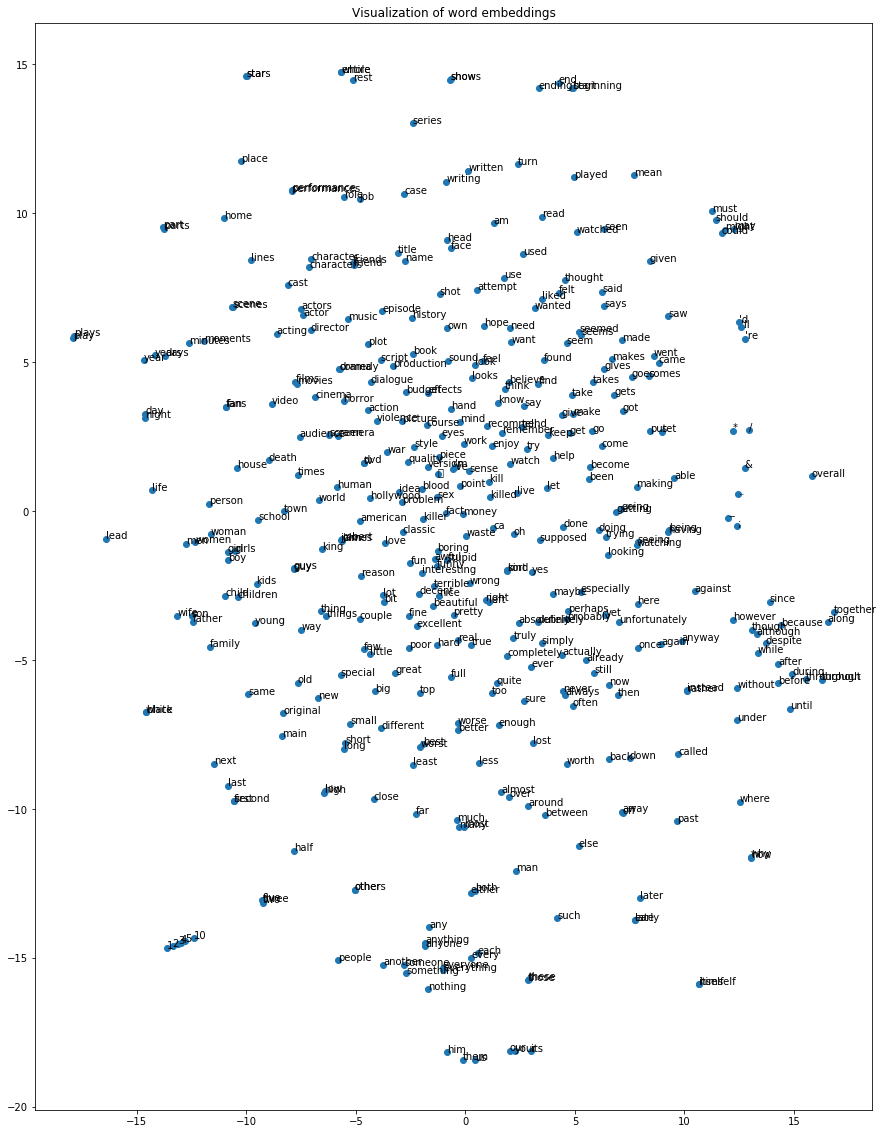

In [28]:
fig, ax = plt.subplots(figsize=(15, 20))
ax.scatter(df_tsne["X"], df_tsne["Y"])

for i, txt in enumerate(df_tsne["word"]):
    ax.annotate(txt, (df_tsne["X"][i], df_tsne["Y"][i]))
plt.title("Visualization of word embeddings")
plt.show()

**TO DO** Let's discuss what we see on the scatter plot !

### Train the classifier
Now that we have fine-tuned our language model, let's train our sentiment classifier !

#### Define the classifier's DataLoaders

**TO DO** Complete the definition of the DataLoaders

In [31]:
# First, let's define the DataBlock
imdb_clas = DataBlock(
    blocks=(TextBlock.from_df('text', seq_len=72, vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'), get_y=ColReader('label'))

# TO DO: 
dls = imdb_clas.dataloaders(df, valid_col='is_valid', bs=64)
dls.show_batch(max_n=2)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot … which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",positive


**Define the learner**

In [32]:
learn_clas = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

**Loading the encoder** 

Here, we load the encoder that we have saved after fine-tuning the language model.

**TO DO** Complete loading the encoder. **Note**: under `path` a folder named `models` is created to save the encoder.

In [33]:
learn_clas = learn_clas.load_encoder(path/'models'/'finetuned')

Let's find the right learning rate !

In [34]:
learn_clas.lr_find()

KeyboardInterrupt: 

Let's use the learning rate we found to fine tune the model.

In [35]:
learn_clas.fine_tune(4, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.622823,0.586919,0.695000,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.455962,0.508467,0.775000,00:41
1,0.418274,0.477812,0.780000,00:41
2,0.372782,0.539968,0.750000,00:41
3,0.339561,0.512966,0.765000,00:41


### OPTIONAL: Gradual unfreezing

Instead of fine-tuning the model using `fine_tune()`, we leverage gradual unfreezing.

In [34]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

In [35]:
learn = learn.load_encoder(path/'models'/'finetuned')

In [36]:
learn.fit_one_cycle(1, 2e-2)
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.598332,0.598947,0.720000,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.464861,0.494995,0.800000,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.345892,0.408132,0.810000,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.256473,0.385331,0.815000,00:41
1,0.231547,0.412497,0.805000,00:41
2,0.203787,0.396763,0.820000,00:41
3,0.178303,0.413583,0.795000,00:41
